In [1]:
import json
import math
import numpy as np
import sys
import os
from scipy.stats import entropy
import matplotlib.pyplot as plt
import pandas as pd
import zipfile

from libs.entropy_coding import slq
from libs.entropy_coding import vlq
from libs.data_transformation import delta_encoding
from libs.data_transformation import predictive_coding
from libs.data_transformation import split_data
from libs.entropy_coding import r_golomb

data_file = zipfile.ZipFile('./data/data.zip', 'r')
data = json.load(data_file.open('1661426400[4]-ant121-skifiloc-ang170-iq.json', 'r'))

data_i = np.array(data['i'])
data_q = np.array(data['q'])
data_ant = np.array(data['ant'])


In [2]:
def print_stats(arr, name):
    std_dev = round(np.std(arr), 2)
    min = np.min(arr)
    max = np.max(arr)
    
    print(f'Standard Deviation: {std_dev}')
    print(f'RANGE: [{min},{max}]')
    value,counts = np.unique(arr, return_counts=True)
    print(f'Entropy: {entropy(counts)}')

    slq_arr, data_i_bit_len = slq.encode(arr)
    vlq_arr = vlq.encode(arr)
    golomb = r_golomb.encode(arr, 8)

    print(f'16b_int: {len(slq_arr)} BITS')
    print(f'Variable length quantity: {len(vlq_arr) } BITS')
    print(f'Rice Golomb Coding: {len(golomb) } BITS')

    plt.rcParams["figure.figsize"] = (10,10)
    plt.hist(arr, 500, density=True, facecolor='blue', alpha=0.75)
    plt.grid(True)
    plt.title(f'HISTOGRAM ({name})')
    plt.xlabel('value')
    plt.ylabel('percentage')
    plt.show()

#Original data stats

Standard Deviation: 205.07
RANGE: [-376,385]
Entropy: 5.888667918344744
16b_int: 9984 BITS
Variable length quantity: 8792 BITS
Rice Golomb Coding: 28724 BITS


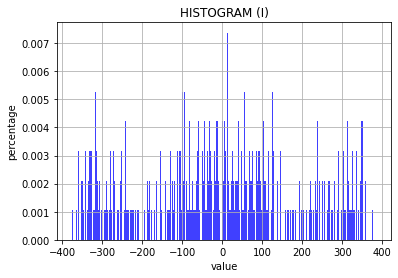

In [3]:
print_stats(data_i, 'I')
#print_stats(data_q, 'Q')

#Delta encoding

Standard Deviation: 79.18
RANGE: [-163,154]
Entropy: 5.36950950642505
16b_int: 9984 BITS
Variable length quantity: 7368 BITS
Rice Golomb Coding: 12614 BITS


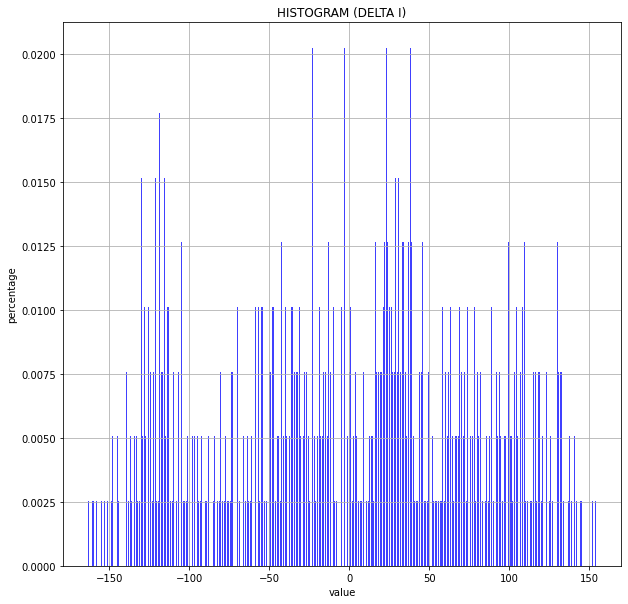

Standard Deviation: 83.12
RANGE: [-326,165]
Entropy: 5.4012321709370745
16b_int: 9984 BITS
Variable length quantity: 7496 BITS
Rice Golomb Coding: 12898 BITS


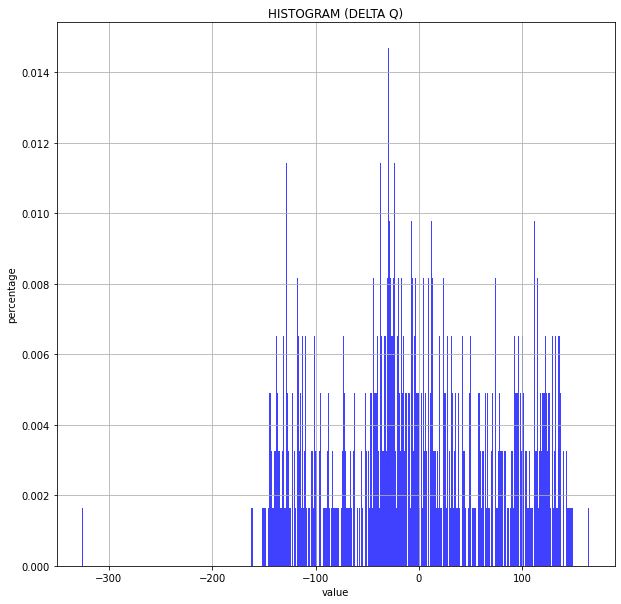

In [4]:
new_i = delta_encoding.encode(data_i)
print_stats(new_i, 'DELTA I')

new_q = delta_encoding.encode(data_q)
print_stats(new_q, 'DELTA Q')

#Delta delta coding

Standard Deviation: 35.72
RANGE: [-79,145]
Entropy: 4.779964082391823
16b_int: 9984 BITS
Variable length quantity: 5176 BITS
Rice Golomb Coding: 6829 BITS


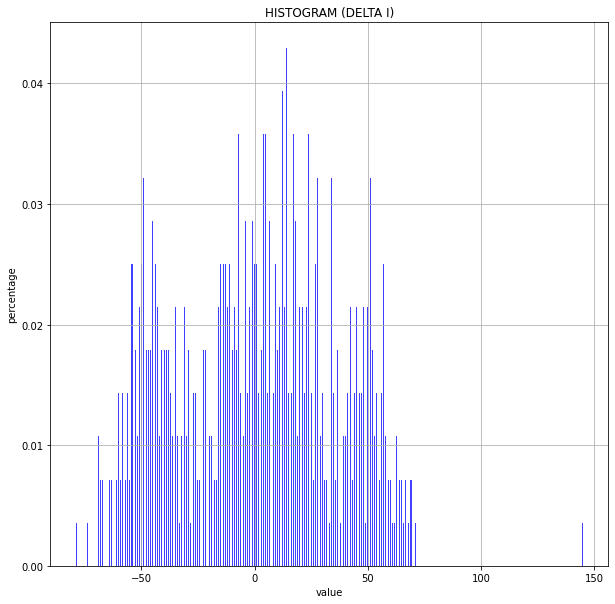

Standard Deviation: 43.87
RANGE: [-326,419]
Entropy: 4.846028572581581
16b_int: 9984 BITS
Variable length quantity: 5384 BITS
Rice Golomb Coding: 7316 BITS


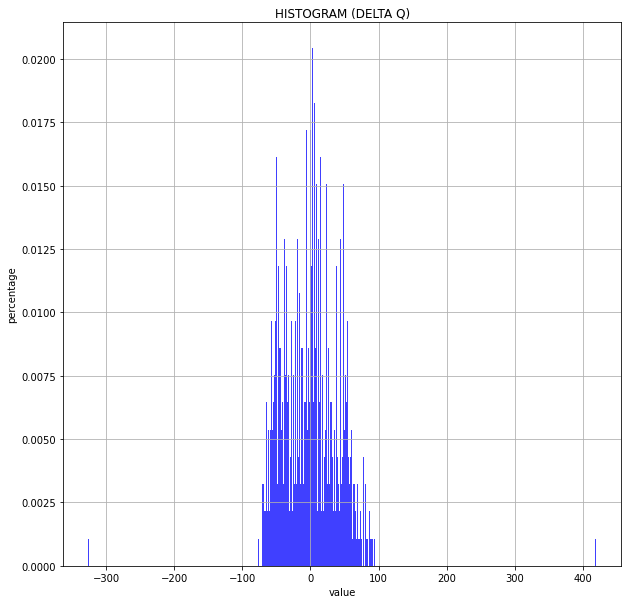

In [5]:
new_i = delta_encoding.encode(delta_encoding.encode(data_i))
print_stats(new_i, 'DELTA I')

new_q = delta_encoding.encode(delta_encoding.encode(data_q))
print_stats(new_q, 'DELTA Q')

In [6]:
# pc_i, pc_q, predictor = predictive_coding.encode_one_sine_delta(data)


# _, data_sep = split_data.split_by_ant(data['i'], data['ant'])

# amp = predictor['amp']
# phase = predictor['phase']
# offset = predictor['offset']
# freq = predictor['freq']

# print_stats(pc_i, 'I')
# print_stats(delta_encoding.encode(pc_q), 'PREDICTION Q')

# time_axs = np.linspace(0, 156e-6, 625)

# signal = amp * np.sin(2*np.pi*freq*time_axs + phase)
# signal = amp * np.sin(2*np.pi*freq*time_axs + phase)

# plt.rcParams["figure.figsize"] = (50,10)
# plt.figure()


# plt.plot(data_sep['2'])

# plt.rcParams["figure.figsize"] = (50,10)
# plt.figure()


# plt.plot(data_i)
# plt.plot(signal)

# plt.figure()
# plt.plot(pc_i)
# #plt.plot(delta_encoding.encode(data_i))



Standard Deviation: 17.0
RANGE: [-71,67]
Entropy: 4.093206132505901
16b_int: 4992 BITS
Variable length quantity: 5008 BITS
Rice Golomb Coding: 4203 BITS


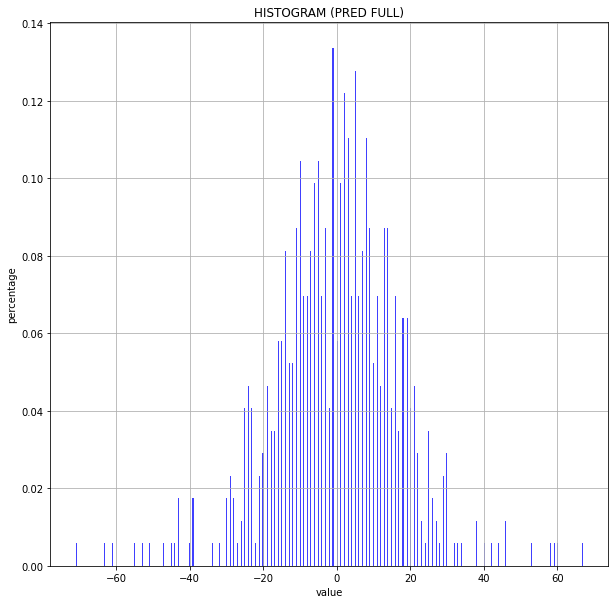

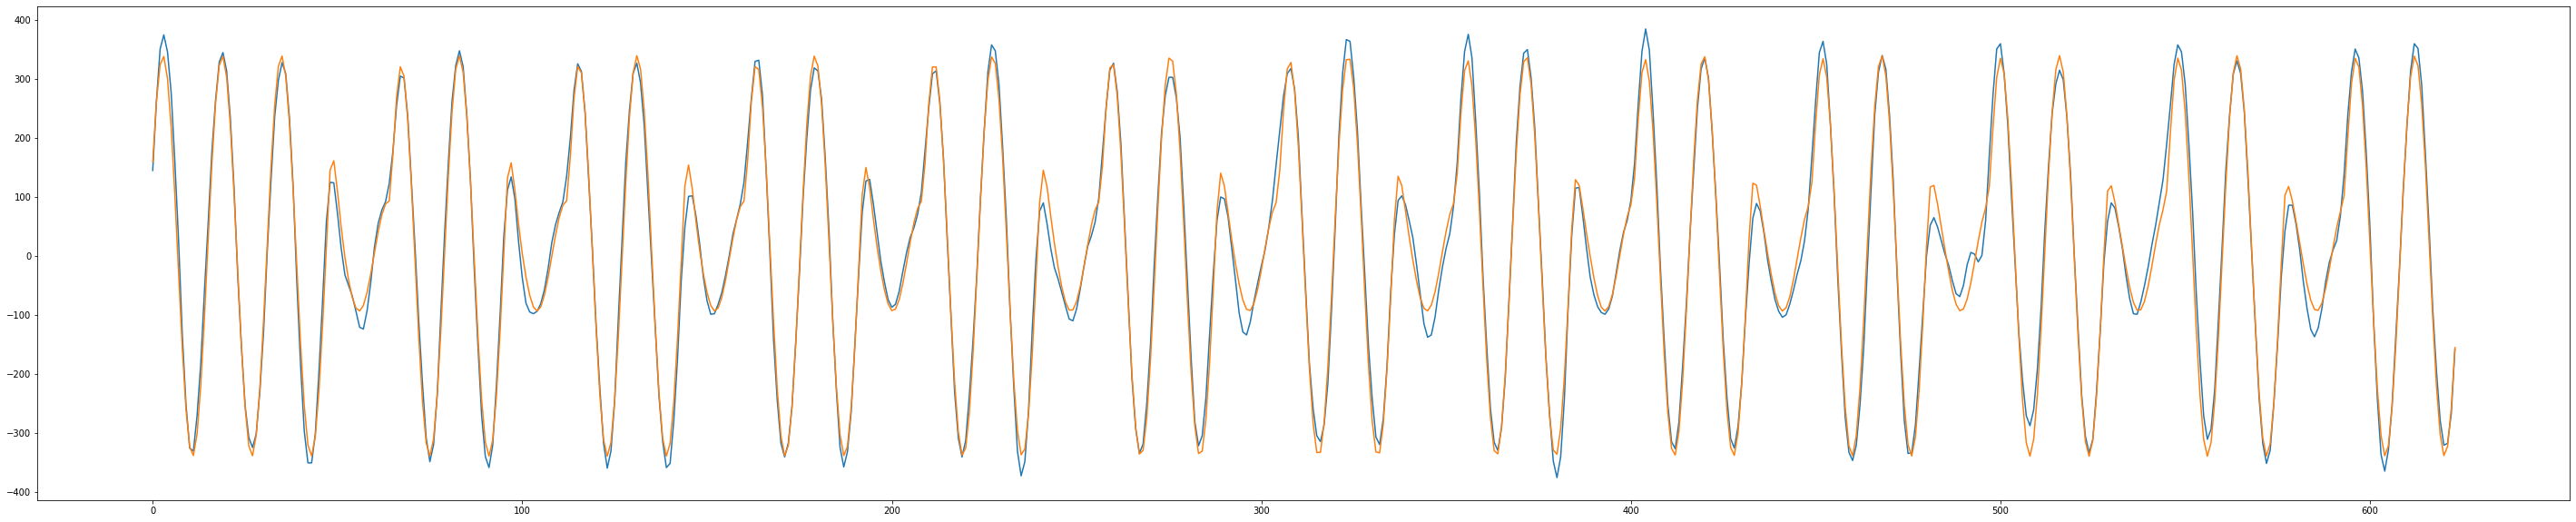

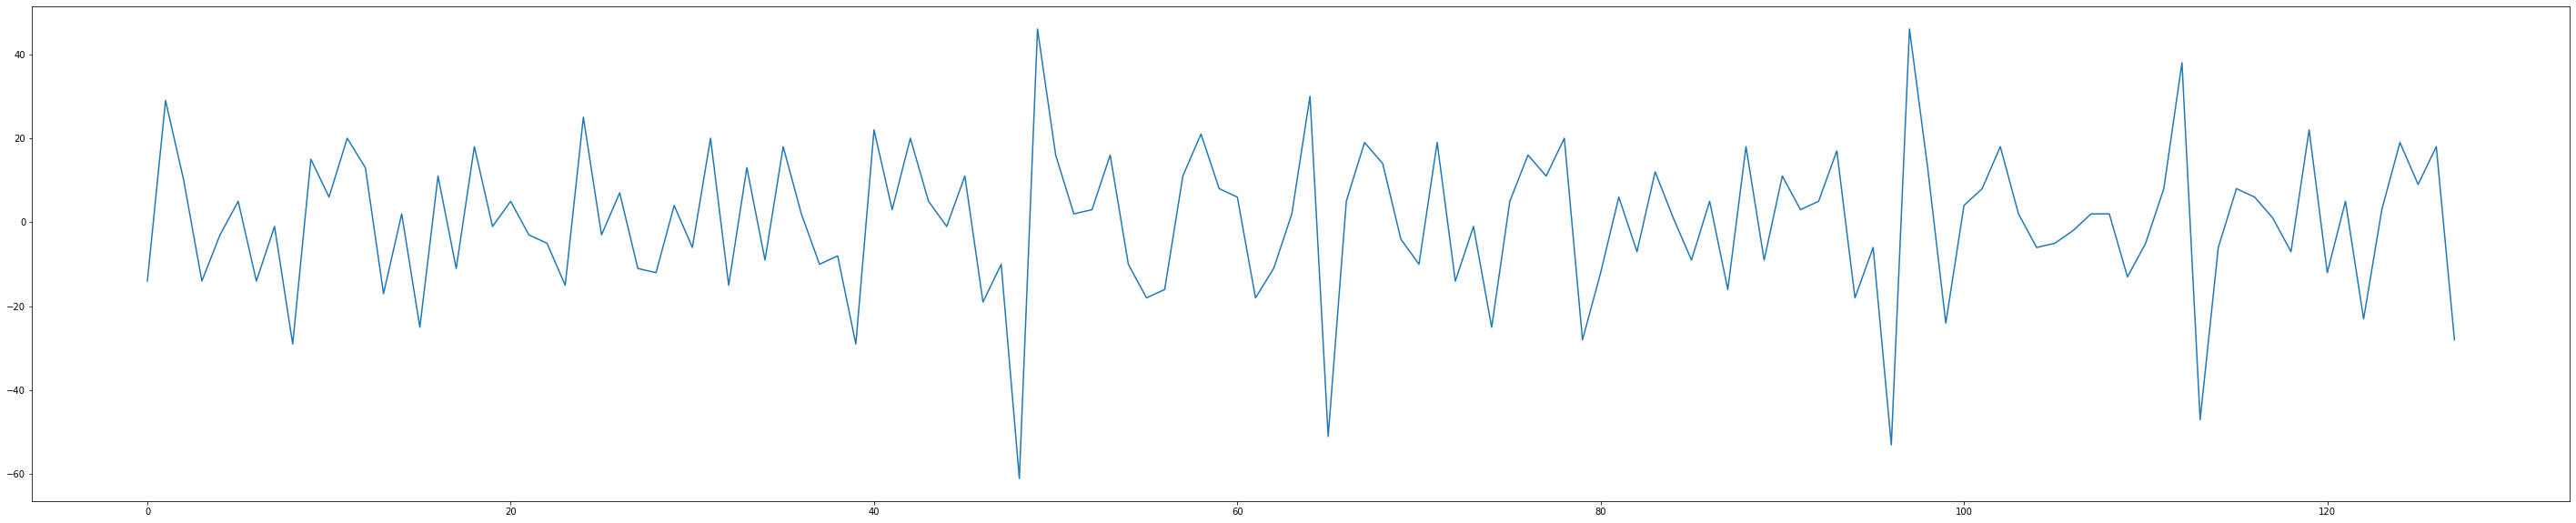

In [7]:
sine1 = predictive_coding.sine_predictor(data['i'], data['ant'])
sine2 = predictive_coding.sine_predictor_wf(data['i'], data['ant'], sine1['freq'])


predicted_vals = predictive_coding.mix_clean(sine1, sine2, data['ant'])
prediction_err = predictive_coding.diff(data['i'], predicted_vals)

print_stats(delta_encoding.encode(delta_encoding.encode(prediction_err)), 'PRED FULL')

_, ant2data = split_data.split_by_ant(data['i'], data['ant'])

plt.rcParams["figure.figsize"] = (50,10)
plt.figure()
plt.plot(data['i'])
plt.plot(predictive_coding.mix_clean(sine1, sine2, data['ant']))
# plt.plot(predictive_coding.generate_sine(sine1, split_data.time_len(data_ant)))
# plt.plot(predictive_coding.generate_sine(sine2, split_data.time_len(data_ant)))


plt.rcParams["figure.figsize"] = (50,10)
plt.figure()
plt.plot(delta_encoding.encode(delta_encoding.encode(prediction_err))[:128])



In [8]:
# for idx in range(9):
#     data_file = zipfile.ZipFile('./data/data.zip', 'r')
#     data = json.load(data_file.open(f'1661426400[{idx}]-ant121-skifiloc-ang170-iq.json', 'r'))

#     data_i = np.array(data['i'])
#     data_q = np.array(data['q'])
#     data_ant = np.array(data['ant'])

#     windows = split_data.split_by_windows(data['i'], data['ant'])

#     plt.rcParams["figure.figsize"] = (50,10)
#     plt.figure()
#     plt.xticks(np.arange(0, 32, 1.0))
#     for window in windows['2']:
#         plt.plot(window)




In [9]:
data_file.close()